In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import umap

from neuropacks import ECOG
from pyuoi.decomposition import UoI_NMF
from sklearn.decomposition import NMF
from sklearn.cluster import DBSCAN

from utils import *
%matplotlib inline

In [2]:
data_path = '/storage/data/ecog/r32_b7.mat'
grid_path = '/storage/data/ecog/grdid.mat'

In [3]:
data_path = os.path.join(os.environ['HOME'], 'data/ecog/r32_b7.mat')
grid_path = os.path.join(os.environ['HOME'], 'data/ecog/grdid.mat')

In [4]:
ecog = ECOG(
    data_path=data_path,
    grid_path=grid_path
)

In [5]:
Y = ecog.get_response_matrix(
    bounds=(40, 60),
    band='HG'
)

In [6]:
# kill the dead indices
dead_indices = [19, 21, 0]

In [7]:
Y = Y + np.abs(np.min(Y, axis=0, keepdims=True))
Y[:, dead_indices] = 0
# Y[Y < 0] = 0

# Multiple Ranks

In [9]:
uoi = UoI_NMF(
    n_boots=30,
    ranks=np.arange(2, 31),
    nmf_max_iter=1000)

In [10]:
H_samples = uoi.fit(Y)

Text(0, 0.5, '\\textbf{Discrepancy}')

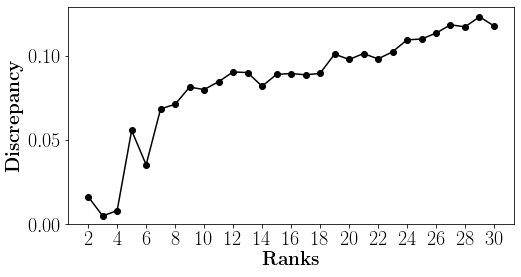

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.arange(2, 31), uoi.dissimilarity_, color='k', marker='o')

ax.set_xticks(np.arange(2, 31, 2))

ax.set_ylim(bottom=0)
ax.set_xlabel(r'\textbf{Ranks}', fontsize=19)
ax.set_ylabel(r'\textbf{Discrepancy}', fontsize=19)

#plt.savefig('NMF_discrepancy.pdf', bbox_inches='tight')

In [35]:
H_min = uoi.bases_samples_

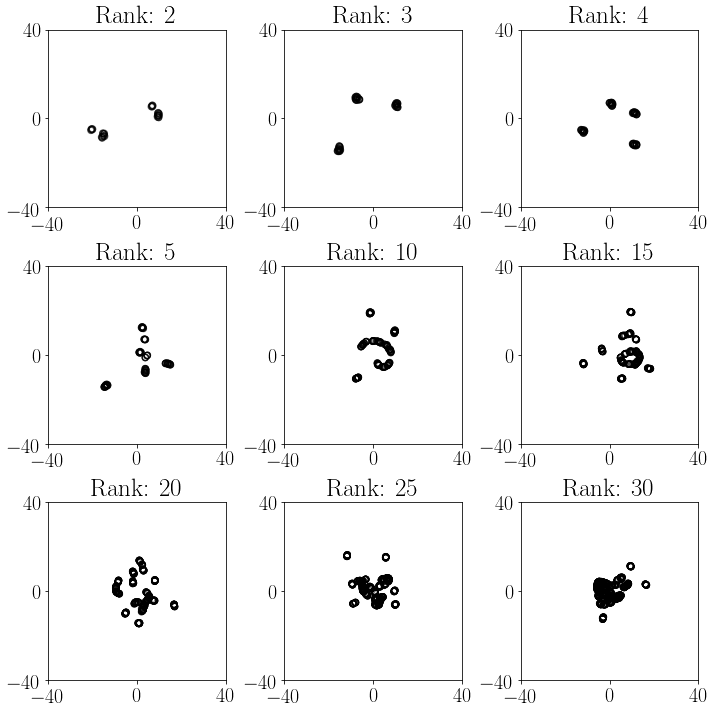

In [74]:
examples = [2, 3, 4, 5, 10, 15, 20, 25, 30]
n_example = len(examples)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))

for idx, example in enumerate(examples):
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(H_samples[example].reshape((30 * example, 128)))
    
    ax = axes.ravel()[idx]
    ax.scatter(embedding[:, 0], embedding[:, 1],
                              color='k', s=40, marker='o', alpha=0.5, facecolors='none', edgecolors='k')
    ax.set_xlim([-40, 40])
    ax.set_ylim([-40, 40])
    ax.set_xticks([-40, 0, 40])
    ax.set_yticks([-40, 0, 40])
    ax.set_title(r'Rank: %s' % example, fontsize=25)
    ax.set_aspect('equal')
    
plt.tight_layout()
plt.savefig('NMF_embeddings.pdf', bbox_inches='tight')

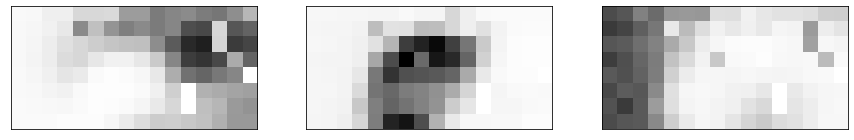

In [51]:
plot_ecog_bases(uoi.components_, ecog)
plt.savefig('UoI_NMF_ecog_bases.pdf', bbox_inches='tight')

In [49]:
nmf = NMF(n_components=3, init='random')
nmf.fit(Y)

NMF(alpha=0.0, beta_loss='frobenius', init='random', l1_ratio=0.0, max_iter=200,
    n_components=3, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

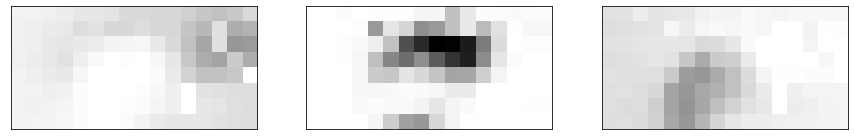

In [52]:
plot_ecog_bases(nmf.components_, ecog)
plt.savefig('NMF_ecog_bases.pdf', bbox_inches='tight')

# Multiple Ranks with Sparsity

In [84]:
uoi = UoI_NMF(
    n_boots=30,
    ranks=np.arange(2, 31),
    nmf_max_iter=1000)

In [85]:
uoi.nmf.set_params(alpha=5.0)

NMF(alpha=5.0, beta_loss='kullback-leibler', init='random', l1_ratio=0.0,
    max_iter=1000, n_components=None, random_state=None, shuffle=False,
    solver='mu', tol=0.0001, verbose=0)

In [87]:
H_samples = uoi.fit(Y)

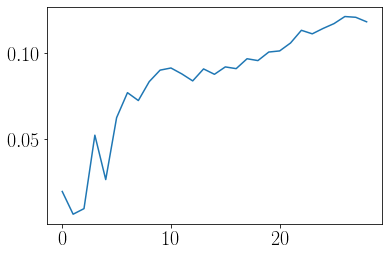

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(np.arange(2, 31), uoi.dissimilarity_, color='k', marker='o')

ax.set_xticks(np.arange(2, 31, 2))

ax.set_ylim(bottom=0)
ax.set_xlabel(r'\textbf{Ranks}', fontsize=19)
ax.set_ylabel(r'\textbf{Discrepancy}', fontsize=19)
ax.set_title(r'\textbf{Using a Sparsity-Based })
plt.savefig('NMF_discrepancy_sparsity.pdf', bbox_inches='tight')

(<Figure size 1080x216 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c2aed3150>,
       dtype=object))

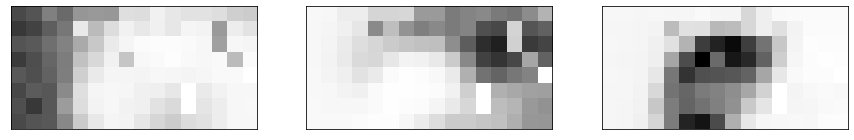

In [90]:
plot_ecog_bases(uoi.components_, ecog)

In [13]:
from pyuoi.decomposition.utils import dissimilarity
from scipy.optimize import linear_sum_assignment

In [14]:
def diss2(H1, H2):
    """
    Calculates the dissimilarity between two sets of NMF bases.

    Parameters
    ----------
    H1 : ndarray, shape (n_components, n_features)
        First set of bases.

    H2 : ndarray, shape (n_components, n_features)
        Second set of bases.

    Returns
    -------
    """
    H1 = H1 / np.linalg.norm(H1, axis=1, keepdims=True)
    H2 = H2 / np.linalg.norm(H2, axis=1, keepdims=True)
    C = - H1.dot(H2.T)
    ri, ci = linear_sum_assignment(C)
    return 1 + (C[ri, ci].sum() / H1.shape[0])

In [17]:
from itertools import combinations

In [22]:
H_samples[3].shape

(30, 3, 128)

In [19]:
gamma = np.zeros(len(uoi.ranks))
# iterate over each rank
for k_idx, k in enumerate(uoi.ranks):
    # extract the bases for each rank
    H_k = H_samples[k]
    for boot1, boot2 in combinations(range(uoi.n_boots), 2):
        gamma[k_idx] += diss2(H_k[boot1], H_k[boot2])

disc2 = (gamma * 2) / (uoi.n_boots * (.n_boots - 1))

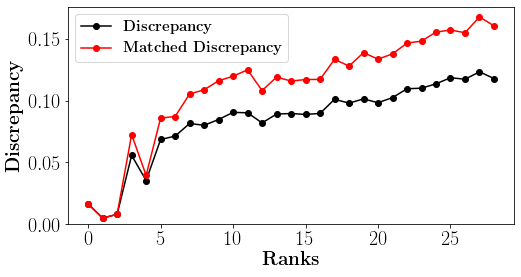

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(uoi.dissimilarity_, color='k', marker='o', label=r'\textbf{Discrepancy}')
ax.plot(disc2, color='r', marker='o', label=r'\textbf{Matched Discrepancy}')

ax.set_ylim(bottom=0)
ax.set_xlabel(r'\textbf{Ranks}', fontsize=19)
ax.set_ylabel(r'\textbf{Discrepancy}', fontsize=19)
ax.legend(loc=2, prop={'size': 15})
plt.savefig('NMF_matched_discrepancy.pdf', bbox_inches='tight')

In [25]:
H_cc_within = np.zeros((len(uoi.ranks), uoi.n_boots))
# iterate over each rank
for k_idx, k in enumerate(uoi.ranks):
    # extract the bases for each rank
    H_k = H_samples[k]
    for boot in range(uoi.n_boots):
        H_current = H_k[boot]
        H_current = H_current / np.linalg.norm(H_current, axis=1, keepdims=True)
        C = np.dot(H_current, H_current.T)
        np.fill_diagonal(C, -np.inf)
        diss = 1 - ((np.max(C, axis=0).sum() + np.max(C, axis=1).sum()) / (2. * k))
        H_cc_within[k_idx, boot] = diss

In [32]:
H_cc_within.mean(axis=1)

array([0.51484523, 0.61703207, 0.56943307, 0.53744115, 0.54275027,
       0.53589868, 0.53387721, 0.53176384, 0.5289774 , 0.51742675,
       0.51043219, 0.51143919, 0.51355741, 0.51444113, 0.50790245,
       0.5063884 , 0.5114227 , 0.50433259, 0.50287995, 0.48861012,
       0.48326691, 0.48390174, 0.47741922, 0.4753801 , 0.46264092,
       0.46319686, 0.46488729, 0.45708348, 0.45124606])

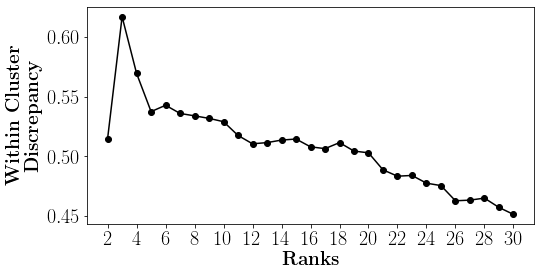

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

ax.plot(uoi.ranks, H_cc_within.mean(axis=1), marker='o', color='k')

ax.set_xlabel(r'\textbf{Ranks}', fontsize=19)
ax.set_ylabel(r'\textbf{Within Cluster}' '\n' r'\textbf{Discrepancy}', fontsize=19)
#plt.savefig('NMF_matched_discrepancy.pdf', bbox_inches='tight')
ax.set_xticks(np.arange(2, 32, 2))
plt.savefig('NMF_within_cluster_discrepancy.pdf', bbox_inches='tight')

In [27]:
n_components = 20
n_features = 64
n_components = np.arange(5, 50)
disses = np.zeros((n_components.size, 2))

for ii, n_c in enumerate(n_components):
    H1 = np.random.rand(n_c, n_features)
    H2 = np.random.rand(n_c, n_features)
    disses[ii, 0] = dissimilarity(H1, H2)
    disses[ii, 1] = diss2(H1, H2)

In [45]:
plt.plot(n_components, disses[:, 0])
plt.plot(n_components, disses[:, 1])

NameError: name 'n_components' is not defined